## Titanic Dataset Overview

The Titanic dataset contains information about passengers aboard the Titanic, including survival status, demographics, and travel details. It has **891 rows** and **12 columns**.

### Data Dictionary

| Variable | Definition | Key/Notes |
|----------|------------|-----------|
| **PassengerId** | Unique identifier for each passenger | `int64` |
| **Survived** | Survival status | `0 = No, 1 = Yes` |
| **Pclass** | Ticket class | `1 = 1st (Upper), 2 = 2nd (Middle), 3 = 3rd (Lower)`<br>A proxy for socio-economic status (SES) |
| **Name** | Passenger's name | `object` |
| **Sex** | Sex | `male, female` |
| **Age** | Age in years | `float64`<br>• Age is fractional if less than 1<br>• Estimated ages are in the form xx.5 |
| **SibSp** | Number of siblings/spouses aboard | `int64`<br>• Sibling = brother, sister, stepbrother, stepsister<br>• Spouse = husband, wife (mistresses and fiancés were ignored) |
| **Parch** | Number of parents/children aboard | `int64`<br>• Parent = mother, father<br>• Child = daughter, son, stepdaughter, stepson<br>• Some children traveled only with a nanny (parch=0) |
| **Ticket** | Ticket number | `object` |
| **Fare** | Passenger fare | `float64` |
| **Cabin** | Cabin number | `object` |
| **Embarked** | Port of embarkation | `C = Cherbourg, Q = Queenstown, S = Southampton` |

### Dataset Characteristics
- **Total passengers**: 891 (sample of the actual 2,224 passengers and crew)
- **Missing values**: 
	- Age: 177 missing (714 non-null)
	- Cabin: 687 missing (204 non-null)
	- Embarked: 2 missing (889 non-null)
- **Target variable**: `Survived` (binary classification)
- **Key features**: Pclass, Sex, Age, SibSp, Parch, Fare, Embarked

The sinking of the RMS Titanic on April 15, 1912, during her maiden voyage is one of the most infamous maritime disasters in history. The "unsinkable" ship collided with an iceberg, resulting in the deaths of 1,502 out of 2,224 passengers and crew. The tragedy was exacerbated by insufficient lifeboats, leading to survival being influenced by factors beyond mere chance.

### The Analytical Challenge
This dataset presents an opportunity to build a predictive model that answers the fundamental question: **"What sorts of people were more likely to survive the Titanic disaster?"**

By analyzing passenger attributes such as:
- Socio-economic status (via Pclass)
- Gender and age demographics
- Family size (SibSp + Parch)
- Travel details (fare, embarkation port)

We can uncover patterns in survival likelihood and build models that predict survival outcomes based on passenger characteristics. This serves as a classic binary classification problem in machine learning, combining historical analysis with predictive modeling techniques.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Loading the Train Dataset from GitHub

The training dataset is loaded directly from the GitHub repository, making it easily accessible from any environment (Colab, Kaggle, local machine, etc.). This approach eliminates the need to manually download the CSV file and ensures reproducibility across different platforms.

In [2]:
train_url = "https://raw.githubusercontent.com/jhlopesalves/classic_workflows/refs/heads/main/supervised_learning/classification/titanic/data/train.csv"
train = pd.read_csv(train_url)

### Basic Inspection of the Data

In [3]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [4]:
train.shape

(891, 12)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Exploratory Data Analysis (EDA)

1. **Feature Distributions**: Examine how passengers are distributed across categorical variables (Sex, Passenger Class, Embarkation Port, Parental/Child Relations)
2. **Survival Patterns**: Analyze survival rates across different demographic and socio-economic groups
3. **Age Analysis**: Explore age distributions and their relationship with survival outcomes
4. **Cabin Information**: Investigate the impact of cabin availability on survival likelihood
5. **Missing Data**: Develop strategies for handling missing values in Age and other columns

In [6]:
# Missingness
train.isna().sum().sort_values(ascending=False)

,0
Cabin,687
Age,177
Embarked,2
PassengerId,0
Name,0
Pclass,0
Survived,0
Sex,0
Parch,0
SibSp,0


### Basic Plots 

In [7]:
# Enables Seaborn to use matplotlib colour codes
sns.set_color_codes("bright")

### Ad hoc Transformations and Data Preparation

In this section, we perform custom transformations and modifications to prepare the data for analysis and visualization:

- **Feature Engineering**: Create new derived features from existing columns (e.g., cabin prefix extraction, missing value indicators);
- **Data Mapping**: Convert categorical codes to human-readable labels for better interpretability;
- **Missing Value Handling**: Develop strategies for imputing missing values in Age and Cabin columns;
- **Data Visualization**: Generate plots and charts to uncover patterns and relationships in survival outcomes;
- **Exploratory Insights**: Extract actionable insights from the transformed data to inform feature engineering and modeling decisions.

In [8]:
train_plot = train.copy()
# Maps Pclass to intuitive/readable values
train_plot["Pclass"] = train_plot["Pclass"].map({1: "1st (Upper)", 2: "2nd (Middle)", 3: "3rd (Lower)"})
# Maps Embarked Acronyms to the actual names of the cities
train_plot["Embarked"] = train_plot["Embarked"].map({"C": "Cherbourg", "Q": "Queenstown", "S": "Southampton"})
# Extracts the prefix of the Cabin codes (it seems to be the only meaningful unit on the cabin codes)
train_plot["CabinCode"] = train_plot["Cabin"].str[0]
# Creates a binary indicator for the missingness on the 'Cabin' column
train_plot["CabinMissing"] = np.where(train_plot["CabinCode"].isna(), "Missing", "Non-missing")
# Creates a binary indicator for the missingness on the 'Age' column
train_plot["AgeMissing"] = np.where(train_plot["Age"].isna(), "Missing", "Non-missing")

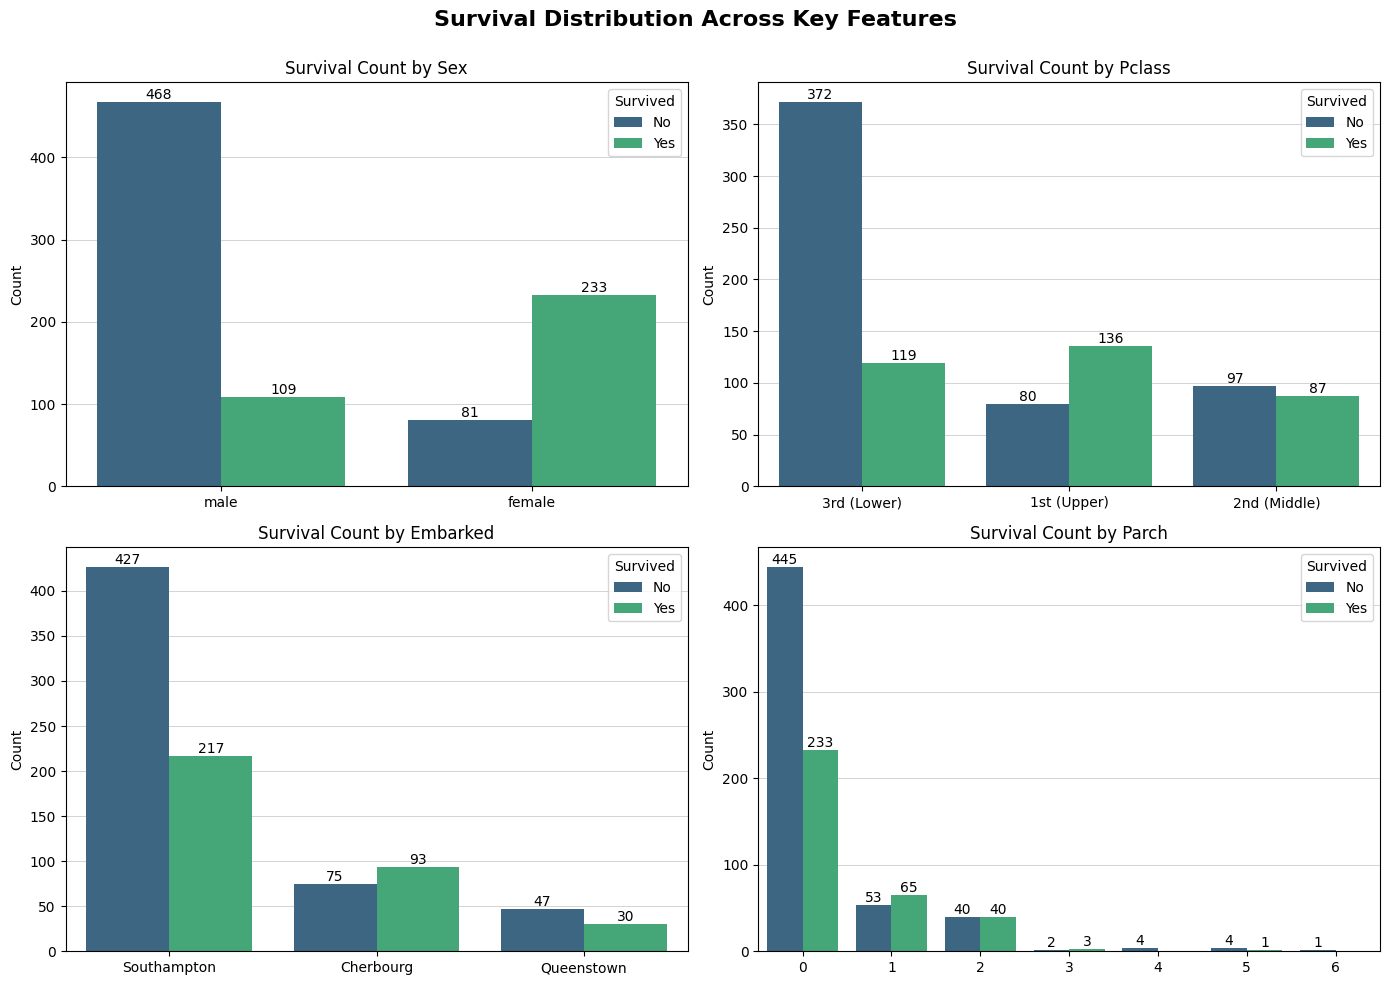

In [9]:
cols_interest = ["Sex", "Pclass", "Embarked", "Parch"]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
axes = axes.flatten()

for i, col in enumerate(cols_interest):
	ax = axes[i]
	sns.countplot(data=train_plot, x=col, hue="Survived", palette="viridis", ax=ax)

	for container in ax.containers:
		ax.bar_label(container, fontsize=10)

	ax.set_title(f"Survival Count by {col}", fontsize=12)
	ax.set(xlabel="", ylabel="Count")  # noqa: E113
	ax.grid(True, axis="y", alpha=0.4, linewidth=0.6, color="grey")
	ax.set_axisbelow(True)
	ax.legend(title="Survived", labels=["No", "Yes"])

plt.suptitle("Survival Distribution Across Key Features", fontsize=16, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

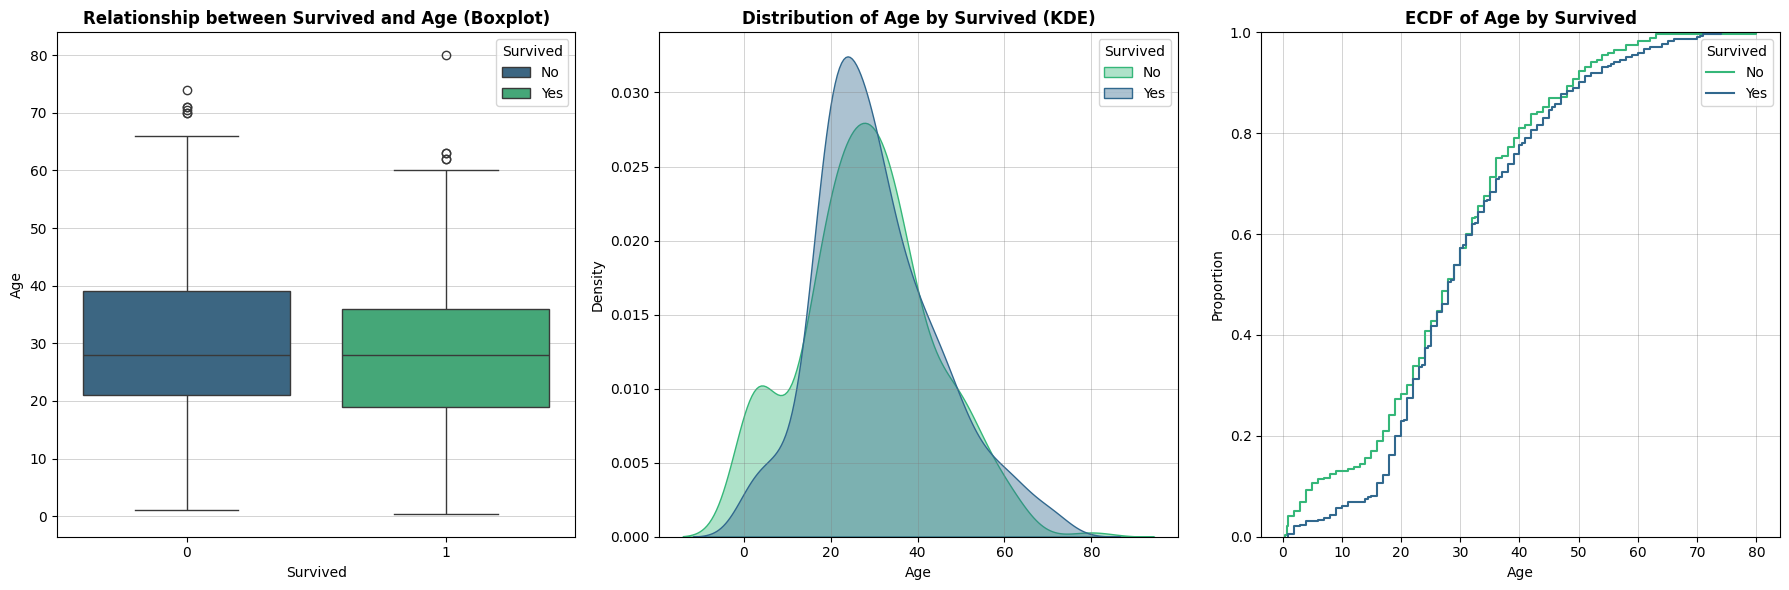

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(18, 6))


sns.boxplot(data=train_plot, x="Survived", y="Age", hue="Survived", palette="viridis", legend=True, ax=ax1)
ax1.set(xlabel="Survived", ylabel="Age")
ax1.set_title("Relationship between Survived and Age (Boxplot)", fontsize=12, fontweight="bold")
ax1.grid(True, axis="y", linewidth=0.6, alpha=0.4, color="grey")
ax1.legend(title="Survived", labels=["No", "Yes"])

sns.kdeplot(data=train_plot, x="Age", hue="Survived", palette="viridis", fill=True, common_norm=False, alpha=0.4, legend=True, ax=ax2)
ax2.set(xlabel="Age", ylabel="Density")
ax2.set_title("Distribution of Age by Survived (KDE)", fontsize=12, fontweight="bold")
ax2.grid(True, linewidth=0.6, alpha=0.4, color="grey")
ax2.legend(title="Survived", labels=["No", "Yes"])

sns.ecdfplot(data=train_plot, x="Age", hue="Survived", palette="viridis", legend=True, ax=ax3)
ax3.set(xlabel="Age", ylabel="Proportion")
ax3.set_title("ECDF of Age by Survived", fontsize=12, fontweight="bold")
ax3.grid(True, linewidth=0.6, alpha=0.4, color="grey")
ax3.legend(title="Survived", labels=["No", "Yes"])

plt.tight_layout()
plt.show()

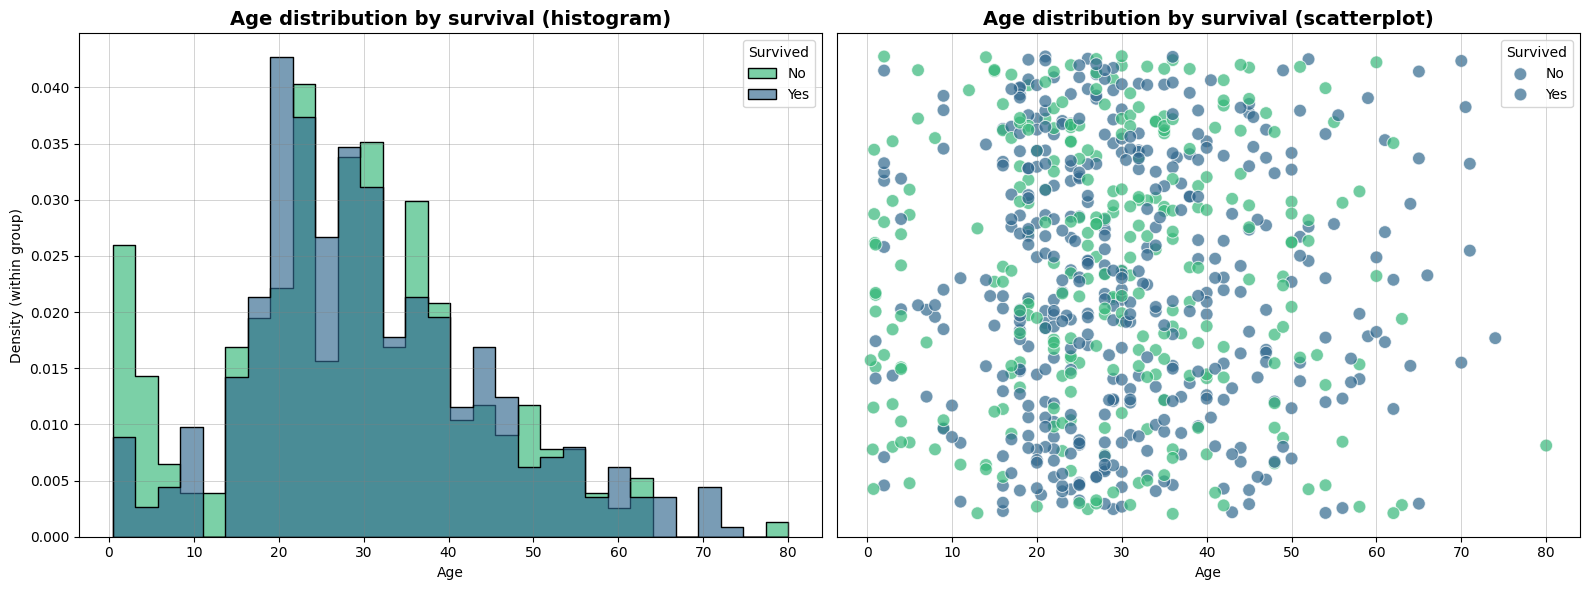

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Histogram
sns.histplot(
	data=train_plot,
	x="Age",
	hue="Survived",
	palette="viridis",
	edgecolor="black",
	bins=30,
	stat="density",
	common_norm=False,
	element="step",
	alpha=0.65,
	ax=ax1,
)
ax1.set_title("Age distribution by survival (histogram)", fontsize=14, fontweight="bold")
ax1.set(xlabel="Age", ylabel="Density (within group)")
ax1.grid(True, linewidth=0.6, alpha=0.4, color="grey")
ax1.legend(title="Survived", labels=["No", "Yes"])

# Right plot: Scatterplot
sns.scatterplot(
	data=train_plot,
	x="Age",
	y=np.random.uniform(0, 0.8, len(train_plot)),
	hue="Survived",
	palette="viridis",
	s=85,
	alpha=0.7,
	ax=ax2,
)
ax2.set_title("Age distribution by survival (scatterplot)", fontsize=14, fontweight="bold")
ax2.set(xlabel="Age", ylabel="")
ax2.grid(True, linewidth=0.6, alpha=0.4, color="grey")
ax2.set_yticks([])  # Remove y-axis ticks since they're arbitrary
ax2.legend(title="Survived", labels=["No", "Yes"])

plt.tight_layout()
plt.show()


> The 'Age' column plays a small role in survival prediction, older people had a slightly lower chance of survival. However, the 'Age' column contains 177 missing values (about 20% of the dataset). To address this, we've got to investigate more and decide what to do about these missing values.

### Feature Engineering - Cabin Feature (Prefix and Missing Indicator)

In [12]:
train_plot.groupby("CabinCode")["Survived"].count()

,Survived
CabinCode,
A,15
B,47
C,59
D,33
E,32
F,13
G,4
T,1


### Visualising the Impact of Cabin Information (prefix of the code) on Survival

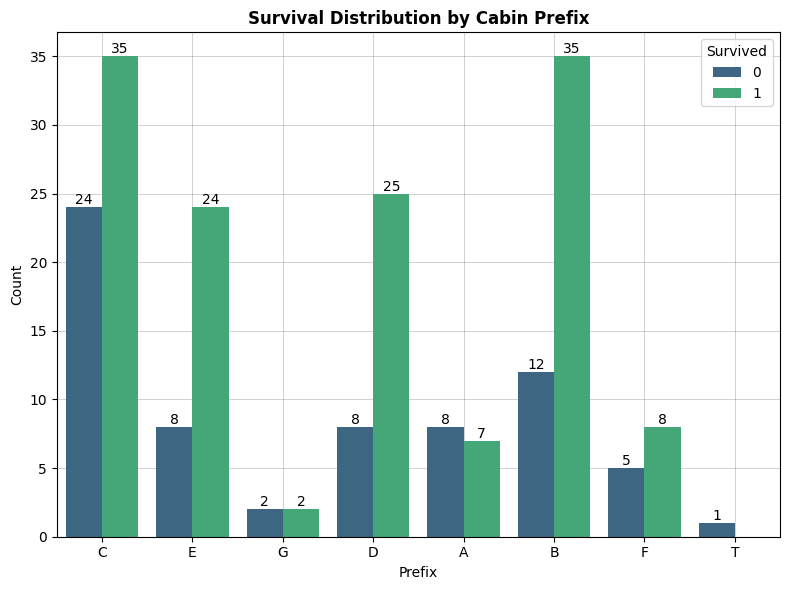

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.countplot(data=train_plot, x="CabinCode", hue="Survived", palette="viridis", ax=ax)

ax.set_title("Survival Distribution by Cabin Prefix", fontsize=12, fontweight="bold")
ax.set(xlabel="Prefix", ylabel="Count")
ax.grid(True, alpha=0.5, linewidth=0.5, color="grey")
ax.set_axisbelow(True)
for container in ax.containers:
	ax.bar_label(container, fontsize=10)

plt.tight_layout()
plt.show()

### Investigating the Impact of Missing Values in the 'Cabin' Column: Assessing Whether Missingness Is Informative or Random

In [14]:
# Subsetting the values where 'Cabin' is missing and not missing
cabin_missing = train_plot[train_plot["CabinMissing"] == "Missing"]
cabin_not_missing = train_plot[train_plot["CabinMissing"] == "Non-missing"]

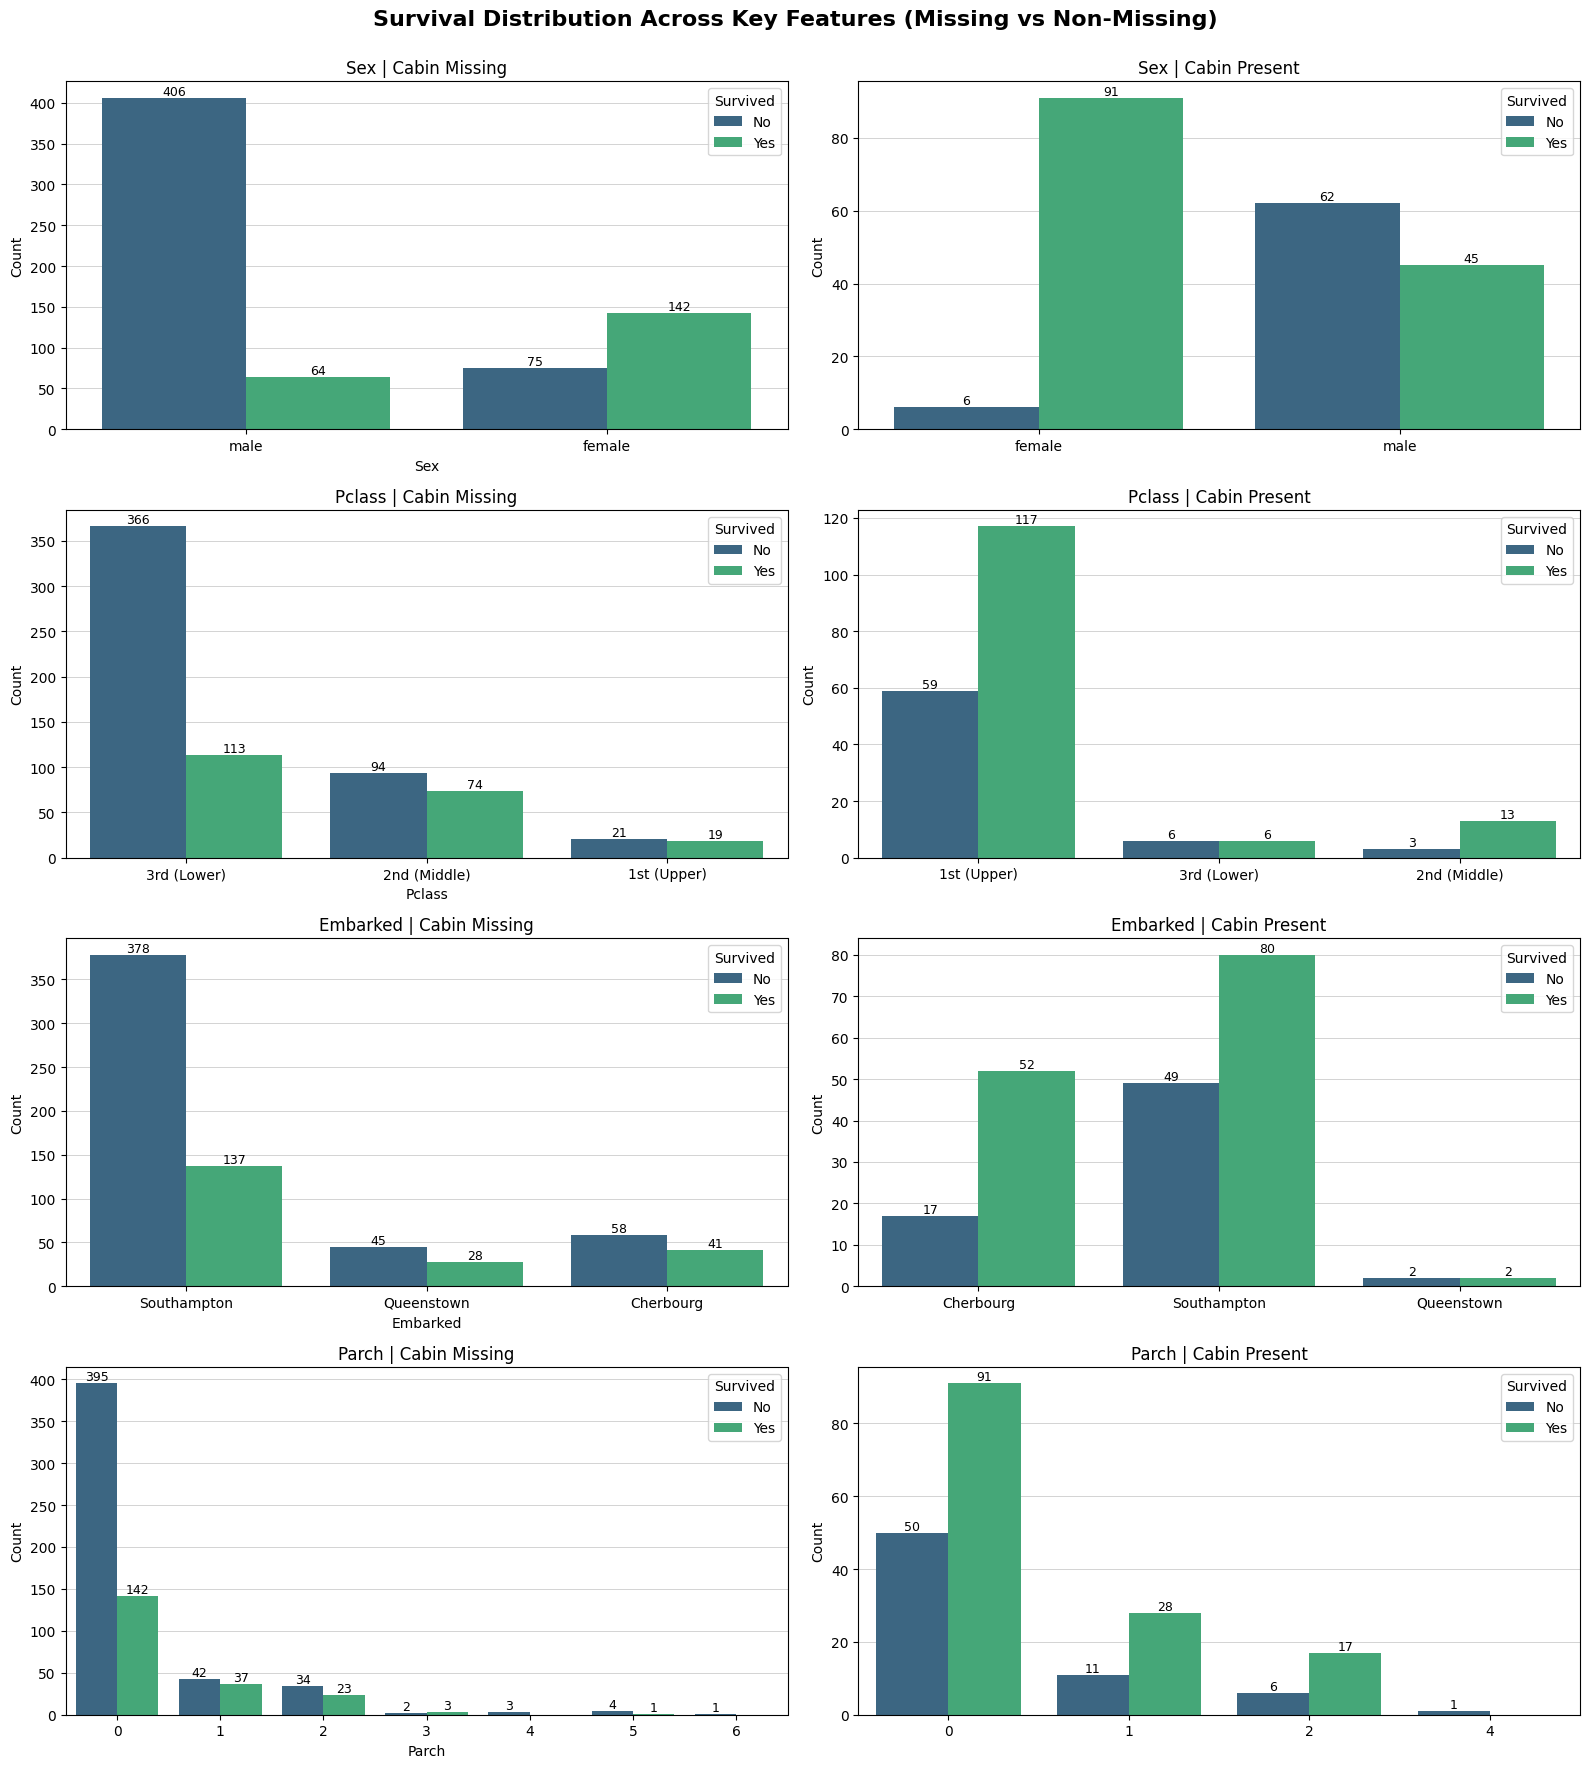

In [15]:
cols_interest = ["Sex", "Pclass", "Embarked", "Parch"]
fig, axes = plt.subplots(nrows=len(cols_interest), ncols=2, figsize=(16, 18))

for i, col in enumerate(cols_interest):
	# Left column: cabin missing
	ax_missing = axes[i, 0]
	sns.countplot(data=cabin_missing, x=col, hue="Survived", palette="viridis", ax=ax_missing)
	ax_missing.set_title(f"{col} | Cabin Missing", fontsize=12)
	ax_missing.set(xlabel=col.title(), ylabel="Count")
	ax_missing.grid(True, axis="y", alpha=0.4, linewidth=0.6, color="grey")
	ax_missing.set_axisbelow(True)
	ax_missing.legend(title="Survived", labels=["No", "Yes"])

	for container in ax_missing.containers:
		ax_missing.bar_label(container, fontsize=9)

	# Right column: cabin present
	ax_present = axes[i, 1]
	sns.countplot(data=cabin_not_missing, x=col, hue="Survived", palette="viridis", ax=ax_present)
	ax_present.set_title(f"{col} | Cabin Present", fontsize=12)
	ax_present.set(xlabel="", ylabel="Count")
	ax_present.grid(True, axis="y", alpha=0.4, linewidth=0.6, color="grey")
	ax_present.set_axisbelow(True)
	ax_present.legend(title="Survived", labels=["No", "Yes"])

	for container in ax_present.containers:
		ax_present.bar_label(container, fontsize=9)

plt.suptitle("Survival Distribution Across Key Features (Missing vs Non-Missing)", fontsize=16, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

> The 'Cabin' column contains a substantial number of missing values (687 out of 891). This may be due to several factors, such as passengers not being assigned a cabin or the information not being recorded correctly. Nevertheless, the presence or absence of a cabin number is likely to carry meaningful value. Clear patterns emerge, for example, passengers traveling in first class are far more likely to have a cabin number recorded than those in third class. This indicates that cabin assignment was correlated with socio-economic status, which may, in turn, have influenced survival outcomes. Therefore, rather than dropping the 'Cabin' column entirely, we can engineer additional features: a binary indicator capturing whether a cabin number was recorded, and a categorical feature derived from the cabin code prefix (the first letter of the cabin identifier).

### Investigating Missing Values from 'Age' Column

In [16]:
age_missing = train_plot[train_plot["AgeMissing"] == "Missing"]
age_not_missing = train_plot[train_plot["AgeMissing"] == "Non-missing"]

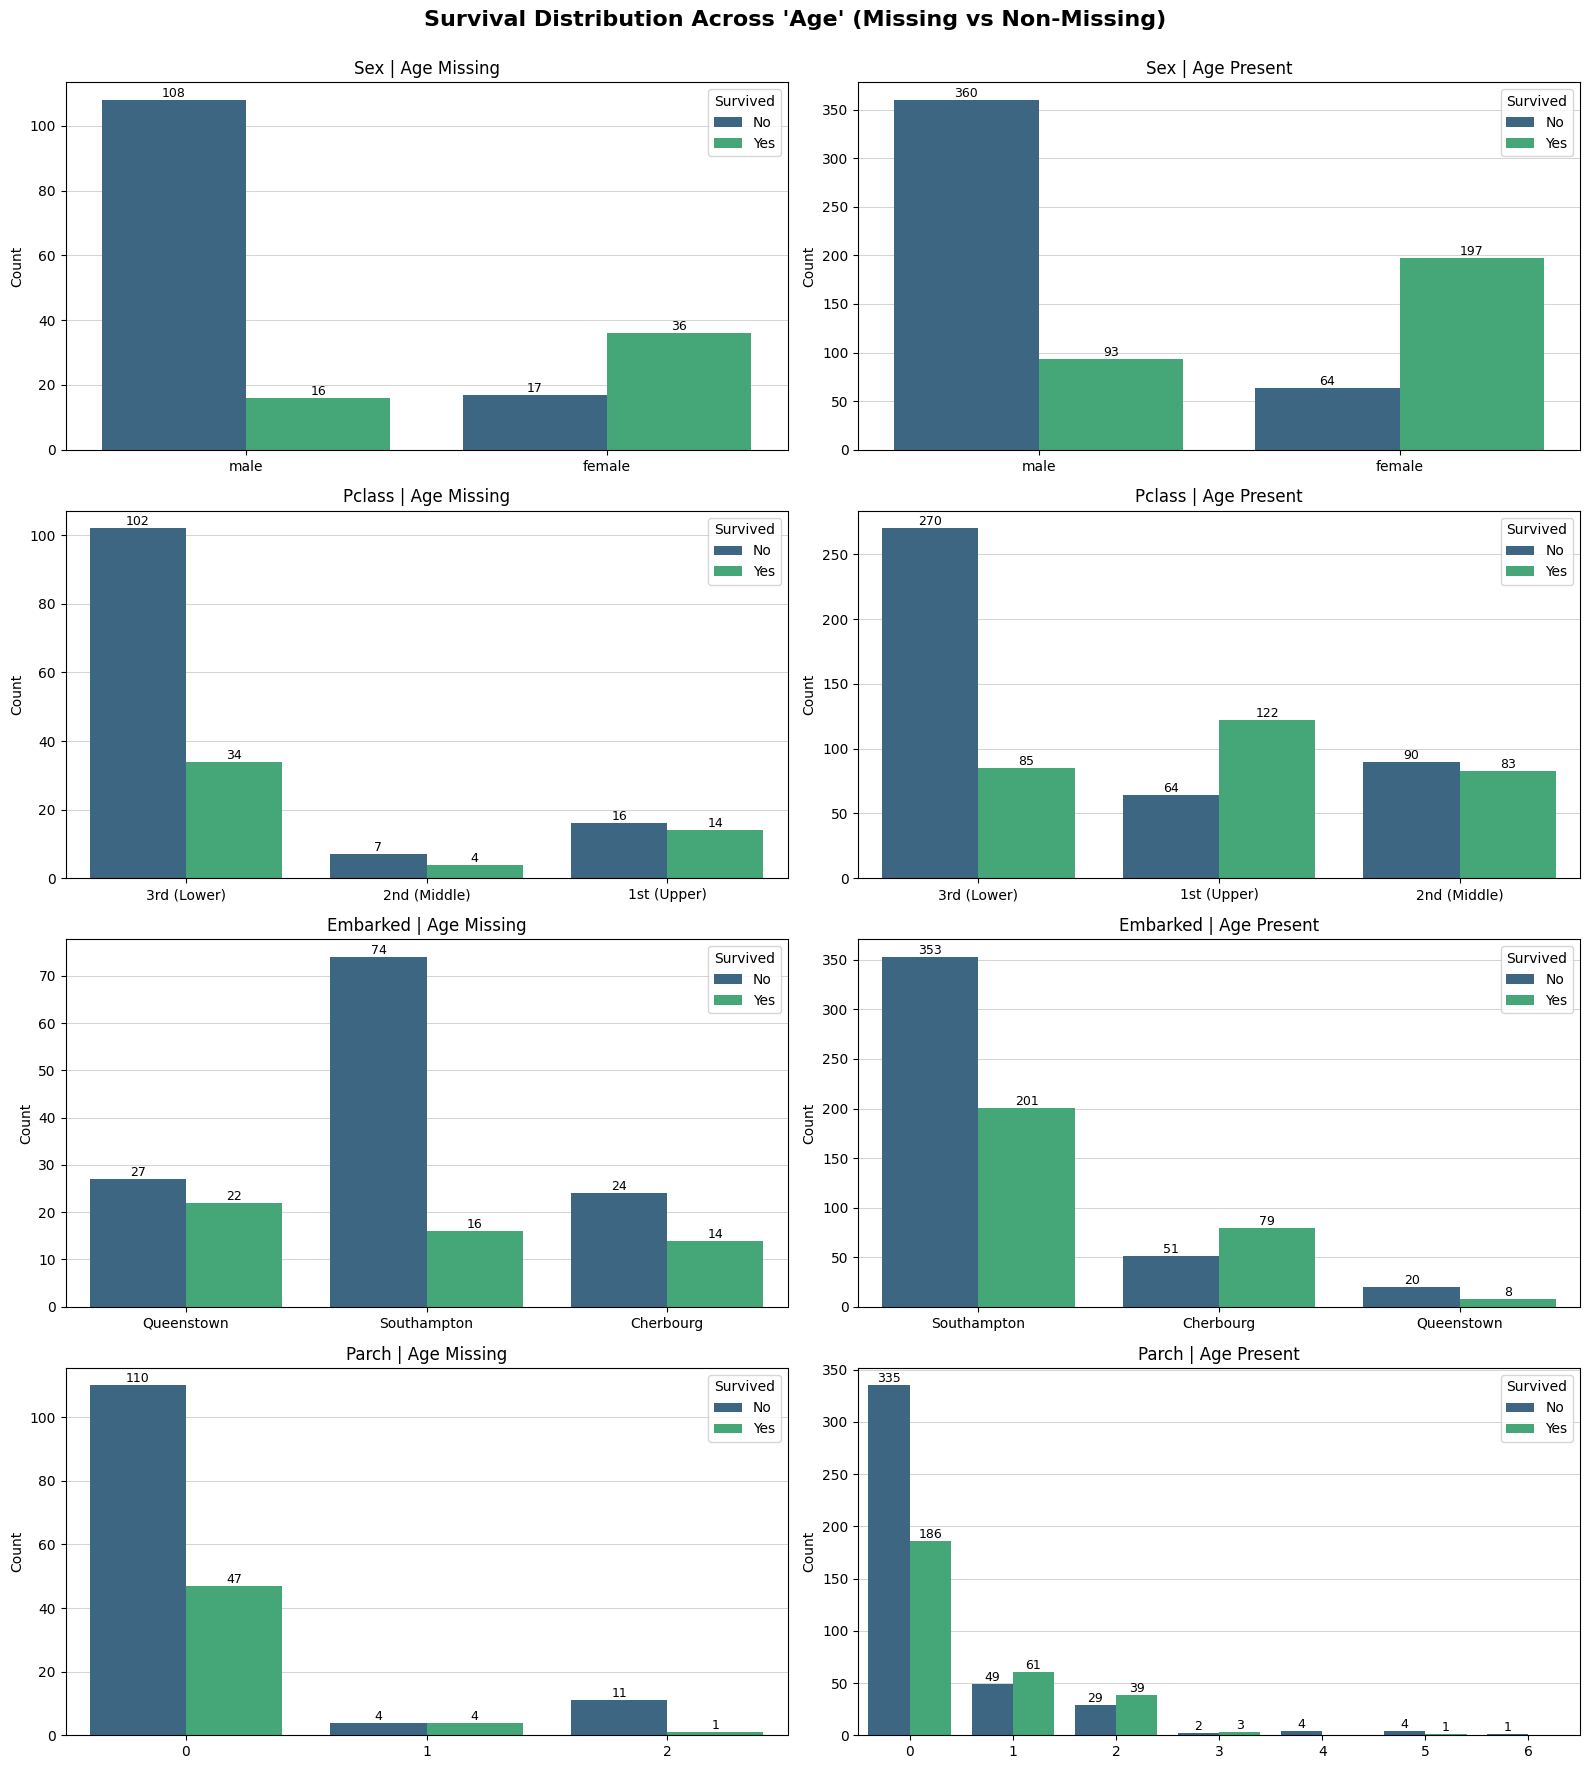

In [17]:
cols_interest = ["Sex", "Pclass", "Embarked", "Parch"]
fig, axes = plt.subplots(nrows=len(cols_interest), ncols=2, figsize=(16, 18))

for i, col in enumerate(cols_interest):
	# Left column: cabin missing
	ax_missing = axes[i, 0]
	sns.countplot(data=age_missing, x=col, hue="Survived", palette="viridis", ax=ax_missing)
	ax_missing.set_title(f"{col} | Age Missing", fontsize=12)
	ax_missing.set(xlabel="", ylabel="Count")
	ax_missing.grid(True, axis="y", alpha=0.4, linewidth=0.6, color="grey")
	ax_missing.set_axisbelow(True)
	ax_missing.legend(title="Survived", labels=["No", "Yes"])

	for container in ax_missing.containers:
		ax_missing.bar_label(container, fontsize=9)

	# Right column: cabin present
	ax_present = axes[i, 1]
	sns.countplot(data=age_not_missing, x=col, hue="Survived", palette="viridis", ax=ax_present)
	ax_present.set_title(f"{col} | Age Present", fontsize=12)
	ax_present.set(xlabel="", ylabel="Count")
	ax_present.grid(True, axis="y", alpha=0.4, linewidth=0.6, color="grey")
	ax_present.set_axisbelow(True)
	ax_present.legend(title="Survived", labels=["No", "Yes"])

	for container in ax_present.containers:
		ax_present.bar_label(container, fontsize=9)

plt.suptitle("Survival Distribution Across 'Age' (Missing vs Non-Missing)", fontsize=16, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

> The 'Age' column contains a considerable number of missing values (177 out of 891). Unlike the 'Cabin' column, age does not appear to exhibit any systematic pattern of missingness when compared with other features. Therefore, the missing age values can be imputed using the median age grouped by Passenger Class and Sex. This approach represents the most reasonable solution, as it minimizes the introduction of bias or unverifiable assumptions while relying solely on information available in the dataset.


In [18]:
missing_embarked = train_plot[train_plot["Embarked"].isna()]
display(missing_embarked)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinCode,CabinMissing,AgeMissing
61,62,1,1st (Upper),"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,B,Non-missing,Non-missing
829,830,1,1st (Upper),"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,B,Non-missing,Non-missing


In [19]:
display(train_plot[(train_plot["Fare"] >= 80.0) & (train_plot["Fare"] <= 150.0) & (train_plot["CabinCode"] == "B")])

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinCode,CabinMissing,AgeMissing
31,32,1,1st (Upper),"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,B78,Cherbourg,B,Non-missing,Missing
61,62,1,1st (Upper),"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0000,B28,NaN,B,Non-missing,Non-missing
195,196,1,1st (Upper),"Lurette, Miss. Elise",female,58.0,0,0,PC 17569,146.5208,B80,Cherbourg,B,Non-missing,Non-missing
257,258,1,1st (Upper),"Cherry, Miss. Gladys",female,30.0,0,0,110152,86.5000,B77,Southampton,B,Non-missing,Non-missing
291,292,1,1st (Upper),"Bishop, Mrs. Dickinson H (Helen Walton)",female,19.0,1,0,11967,91.0792,B49,Cherbourg,B,Non-missing,Non-missing
390,391,1,1st (Upper),"Carter, Mr. William Ernest",male,36.0,1,2,113760,120.0000,B96 B98,Southampton,B,Non-missing,Non-missing
435,436,1,1st (Upper),"Carter, Miss. Lucile Polk",female,14.0,1,2,113760,120.0000,B96 B98,Southampton,B,Non-missing,Non-missing
484,485,1,1st (Upper),"Bishop, Mr. Dickinson H",male,25.0,1,0,11967,91.0792,B49,Cherbourg,B,Non-missing,Non-missing
504,505,1,1st (Upper),"Maioni, Miss. Roberta",female,16.0,0,0,110152,86.5000,B79,Southampton,B,Non-missing,Non-missing
520,521,1,1st (Upper),"Perreault, Miss. Anne",female,30.0,0,0,12749,93.5000,B73,Southampton,B,Non-missing,Non-missing


In [20]:
train_plot[train_plot["Pclass"] == "1st (Upper)"].groupby("Embarked")["Fare"].describe()

,count,mean,std,min,25%,50%,75%,max
Embarked,,,,,,,,
Cherbourg,85.0,104.718529,99.093935,26.55,49.50,78.2667,110.8833,512.3292
Queenstown,2.0,90.000000,0.000000,90.00,90.00,90.0000,90.0000,90.0000
Southampton,127.0,70.364862,58.811278,0.00,29.25,52.0000,83.4750,263.0000


> The ‘Embarked’ column has only two missing values. After a thorough investigation, we found no patterns or strong clues that would allow us to infer the correct ‘Embarked’ values for these two passengers with confidence. However, because public Titanic records are readily accessible, we verified that both passengers with missing ‘Embarked’ values boarded the Titanic at Southampton (S). Therefore, we will impute these missing values with ‘Southampton’ ([source](https://www.encyclopedia-titanica.org/titanic-survivor/amelia-icard.html)).


### Exploring the Possibility of Feature Engineering with the 'Name' Column

In [21]:
title_mapping = {
	"Mlle": "Miss",  # French for Miss
	"Ms": "Miss",
	"Mme": "Mrs",  # French for Mrs
	"Lady": "Rare_Female",
	"Countess": "Rare_Female",
	"Dona": "Rare_Female",
	"Sir": "Rare_Male",
	"Don": "Rare_Male",
	"Jonkheer": "Rare_Male",  # Dutch nobility
	"Col": "Military",
	"Major": "Military",
	"Capt": "Military",
	"Rev": "Clergy",
	"Dr": "Dr",  # Keep separate—mixed survival
}

> The 'Title' extracted from the 'Name' column can provide valuable insights into social status, age group, and gender, which may influence survival outcomes. By categorizing titles into broader groups (e.g., 'Mr', 'Mrs', 'Miss', 'Master', 'Other'), we can create a new feature that captures these social distinctions.

### Exploring the possibility of Feature Engineering with 'Family Size' derived from 'SibSp' and 'Parch' columns

In [22]:
# Family size
train_plot["FamilySize"] = train_plot["SibSp"] + train_plot["Parch"]
train_plot["IsAlone"] = (train_plot["FamilySize"] == 0).astype(int)
train_plot["IsSmallFamily"] = train_plot["FamilySize"].between(1, 3).astype(int)
train_plot["IsLargeFamily"] = (train_plot["FamilySize"] >= 4).astype(int)

In [23]:
train_plot["FamilyCat"] = pd.cut(train_plot["FamilySize"], bins=[0, 1, 4, np.inf], labels=["Alone", "Small", "Large"], right=False)

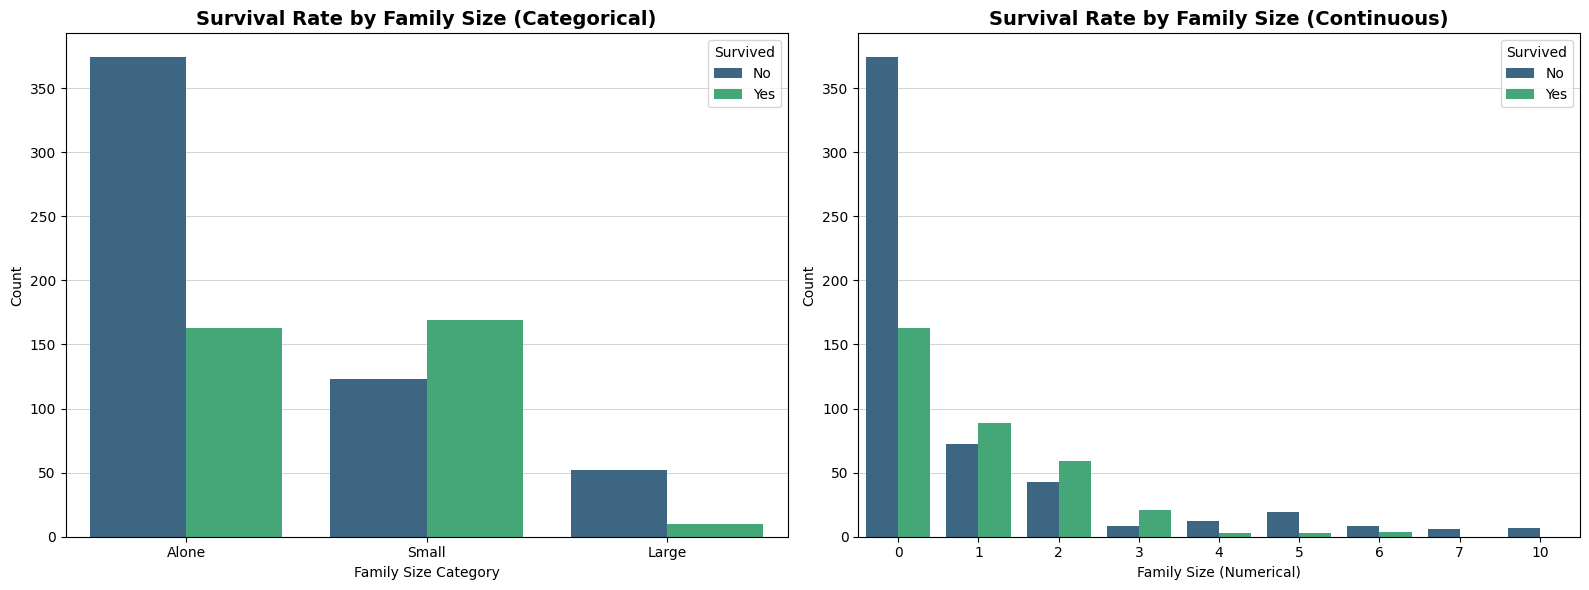

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Categorical family size
sns.countplot(data=train_plot, x="FamilyCat", hue="Survived", palette="viridis", ax=ax1)
ax1.set_title("Survival Rate by Family Size (Categorical)", fontsize=14, fontweight="bold")
ax1.set(xlabel="Family Size Category", ylabel="Count")
ax1.grid(True, axis="y", alpha=0.4, linewidth=0.6, color="grey")
ax1.set_axisbelow(True)
ax1.legend(title="Survived", labels=["No", "Yes"])

# Right plot: Continuous family size
sns.countplot(data=train_plot, x="FamilySize", hue="Survived", palette="viridis", ax=ax2)
ax2.set_title("Survival Rate by Family Size (Continuous)", fontsize=14, fontweight="bold")
ax2.set(xlabel="Family Size (Numerical)", ylabel="Count")
ax2.grid(True, axis="y", alpha=0.4, linewidth=0.6, color="grey")
ax2.set_axisbelow(True)
ax2.legend(title="Survived", labels=["No", "Yes"])

plt.tight_layout()
plt.show()

> The columns 'SibSp' (number of siblings/spouses aboard) and 'Parch' (number of parents/children aboard) can be combined to create a new feature called 'FamilySize'. This feature represents the total number of family members traveling together, which may influence survival chances. Additionally, we can derive together some categorical features referring to the 'bins' of FamilySize, such as 'Alone' (FamilySize = 1), 'Small' (FamilySize = 2-4), and 'Large' (FamilySize >= 5).

### Applying Transformation ad-hoc to the `train_plot` before moving on to Pipelines, Custom transformers, and Full Workflow.

In [25]:
# Fill missing Age values using the median age grouped by Passenger Class and Sex
train_plot["Age"] = train_plot.groupby(["Pclass", "Sex"])["Age"].transform(lambda x: x.fillna(x.median()))
# Note: We keep the 'Cabin' column here - the pipeline's CodeExtractor will handle extracting the code and dropping it
# Fill missing CabinCode values with 'Unknown' to handle missing cabin information
train_plot["CabinCode"] = train_plot["CabinCode"].fillna("Unknown")
# Fill missing Embarked values with 'Southampton' based on external verification
train_plot["Embarked"] = train_plot["Embarked"].fillna("Southampton")
# Apply title mapping to standardize title categories
train_plot["Title"] = train_plot["Name"].str.extract(r" ([A-Za-z]+)\.", expand=False)
train_plot["Title"] = train_plot["Title"].replace(title_mapping)

### Baseline Models Performance on the Transformed Data Without Pipelines

#### Split the Data into Train and Test Sets

In [26]:
from sklearn.model_selection import train_test_split

X = train_plot.drop(labels=["PassengerId", "Name", "SibSp", "Parch", "Ticket", "IsAlone", "IsSmallFamily", "IsLargeFamily"], axis=1)
y = train_plot["Survived"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [27]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 692 to 507
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Survived      712 non-null    int64   
 1   Pclass        712 non-null    object  
 2   Sex           712 non-null    object  
 3   Age           712 non-null    float64 
 4   Fare          712 non-null    float64 
 5   Cabin         160 non-null    object  
 6   Embarked      712 non-null    object  
 7   CabinCode     712 non-null    object  
 8   CabinMissing  712 non-null    object  
 9   AgeMissing    712 non-null    object  
 10  FamilySize    712 non-null    int64   
 11  FamilyCat     712 non-null    category
 12  Title         712 non-null    object  
dtypes: category(1), float64(2), int64(2), object(8)
memory usage: 73.1+ KB


In [28]:
num_cols = ["Age", "Fare", "FamilySize"]
cat_cols = ["Sex", "Embarked", "Title", "CabinCode", "CabinMissing", "AgeMissing", "FamilyCat"]

## Baseline Model Basic ColumnTransformer and Model Training Without Full/Final Pipeline

In [29]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

preprocessor = ColumnTransformer(
	transformers=[("scaler", StandardScaler(), num_cols), ("categorical", OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore"), cat_cols)],
	remainder="drop",
)

base_pipe = Pipeline(steps=[("preprocessing", preprocessor), ("model", LogisticRegression(max_iter=1000, random_state=42))])

In [30]:
from sklearn.metrics import classification_report

base_pipe.fit(X_train, y_train)
y_pred_base = base_pipe.predict(X_test)
y_pred_base_proba = base_pipe.predict_proba(X_test)
print(classification_report(y_true=y_test, y_pred=y_pred_base))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86       110
           1       0.79      0.75      0.77        69

    accuracy                           0.83       179
   macro avg       0.82      0.81      0.82       179
weighted avg       0.83      0.83      0.83       179



In [31]:
from numpy.typing import ArrayLike
from sklearn.base import BaseEstimator
from sklearn.metrics import average_precision_score, confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve


def classification_evaluation(y_true: ArrayLike, X_test: pd.DataFrame | ArrayLike, estimator: BaseEstimator):
	if not isinstance(y_true, (np.ndarray, pd.DataFrame, pd.Series, list)):
		raise TypeError(f"y_true must be array-like, got {type(y_true).__name__}")
	if not isinstance(X_test, (np.ndarray, pd.DataFrame)):
		raise TypeError(f"X_test must be either an Array or a DataFrame, got {type(X_test).__name__}")
	if not isinstance(estimator, BaseEstimator):
		raise TypeError(f"estimator must be a Scikit-Learn Estimator, got {type(estimator).__name__}")

	fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))

	# Get predictions and probabilities
	y_pred = estimator.predict(X_test)
	y_proba = estimator.predict_proba(X_test)[:, 1]

	# Confusion Matrix
	cm = confusion_matrix(y_true=y_true, y_pred=y_pred, normalize="true")
	cm_df = pd.DataFrame(
		data=cm,
		index=["True Negative", "True Positive"],
		columns=["Pred Negative", "Pred Positive"],
	)

	sns.heatmap(
		data=cm_df,
		annot=True,
		fmt=".2%" if cm.max() <= 1 else "d",
		cmap="Blues",
		cbar_kws={"label": "Proportion"},
		ax=axes[0],
	)
	axes[0].set_title("Confusion Matrix\n(Normalised by True Class)", fontweight="bold", pad=9)
	axes[0].set_xlabel("Predicted Label")
	axes[0].set_ylabel("True Label")
	# Roc Curve
	fpr, tpr, _ = roc_curve(y_true=y_true, y_score=y_proba)
	roc_auc = roc_auc_score(y_true=y_true, y_score=y_proba)

	roc_df = pd.DataFrame({
		"False Positive Rate": fpr,
		"True Positive Rate": tpr,
	})

	sns.lineplot(data=roc_df, x="False Positive Rate", y="True Positive Rate", ax=axes[1], linewidth=2.5, color="darkorange", label=f"Model (AUC = {roc_auc:.3f})")

	axes[1].axline((0, 0), (1, 1), color="navy", linestyle="--", alpha=0.5, label="Chance (AUC = 0.5)")
	axes[1].set_xlim([-0.02, 1.02])
	axes[1].set_ylim([-0.02, 1.02])
	axes[1].legend(loc="lower right", frameon=True, fancybox=True, shadow=True)
	axes[1].grid(True, alpha=0.4, linewidth=0.4, color="grey")

	# Precision Recall Curve
	precision, recall, _ = precision_recall_curve(y_true=y_true, y_score=y_proba)
	avg_precision = average_precision_score(y_true=y_true, y_score=y_proba)
	baseline = np.mean(y_true)

	pr_df = pd.DataFrame({
		"Recall": recall,
		"Precision": precision,
	})

	sns.lineplot(
		data=pr_df,
		x="Recall",
		y="Precision",
		ax=axes[2],
		linewidth=2.5,
		color="forestgreen",
		label=f"Model (AP = {avg_precision:.3f})",
	)
	# Add baseline (prevalence line)
	axes[2].axhline(
		y=baseline,
		color="dimgrey",
		linestyle="--",
		linewidth=2,
		alpha=0.7,
		label=f"Baseline (Prevalence = {baseline:.3f})",
	)

	axes[2].set_title("Precision-Recall Curve", fontweight="bold", pad=9)
	axes[2].set_xlabel("Recall (Sensitivity)")
	axes[2].set_ylabel("Precision")
	axes[2].set_xlim([-0.02, 1.02])
	axes[2].set_ylim([0.0, 1.05])
	axes[2].legend(loc="best", frameon=True, fancybox=True, shadow=True)
	axes[2].grid(True, alpha=0.4, linewidth=0.4, color="grey")

	if hasattr(estimator, "named_steps") and "model" in estimator.named_steps:
		model_name = estimator.named_steps["model"].__class__.__name__
	elif hasattr(estimator, "steps"):
		model_name = estimator.steps[-1][1].__class__.__name__
	else:
		model_name = estimator.__class__.__name__

	plt.suptitle(f"Binary Classification: {model_name}", fontsize=14, fontweight="bold")
	plt.tight_layout()
	plt.show()

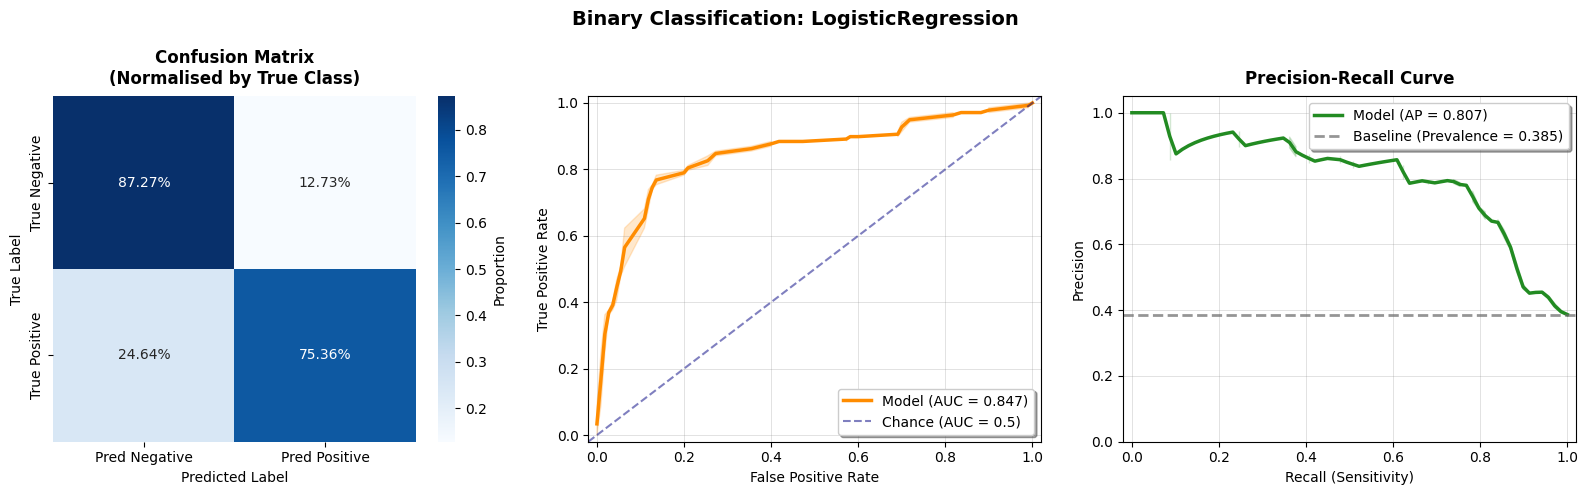

In [32]:
classification_evaluation(y_true=y_test, X_test=X_test, estimator=base_pipe)

## Evaluating First Round of Candidates Models

### 1) RandomForestClassifier

In [33]:
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

preprocessor_rf = ColumnTransformer(
	transformers=[("scaler", StandardScaler(), num_cols), ("categorical", OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore"), cat_cols)],
	remainder="drop",
)

rf_pipe = Pipeline(steps=[("preprocessing", preprocessor), ("model", RandomForestClassifier(n_jobs=-1, random_state=42))])

In [34]:
from sklearn.metrics import classification_report

rf_pipe.fit(X_train, y_train)
y_pred_rf = rf_pipe.predict(X_test)
y_pred_rf_proba = rf_pipe.predict_proba(X_test)
print(classification_report(y_true=y_test, y_pred=y_pred_rf))

              precision    recall  f1-score   support

           0       0.79      0.85      0.82       110
           1       0.73      0.65      0.69        69

    accuracy                           0.77       179
   macro avg       0.76      0.75      0.75       179
weighted avg       0.77      0.77      0.77       179



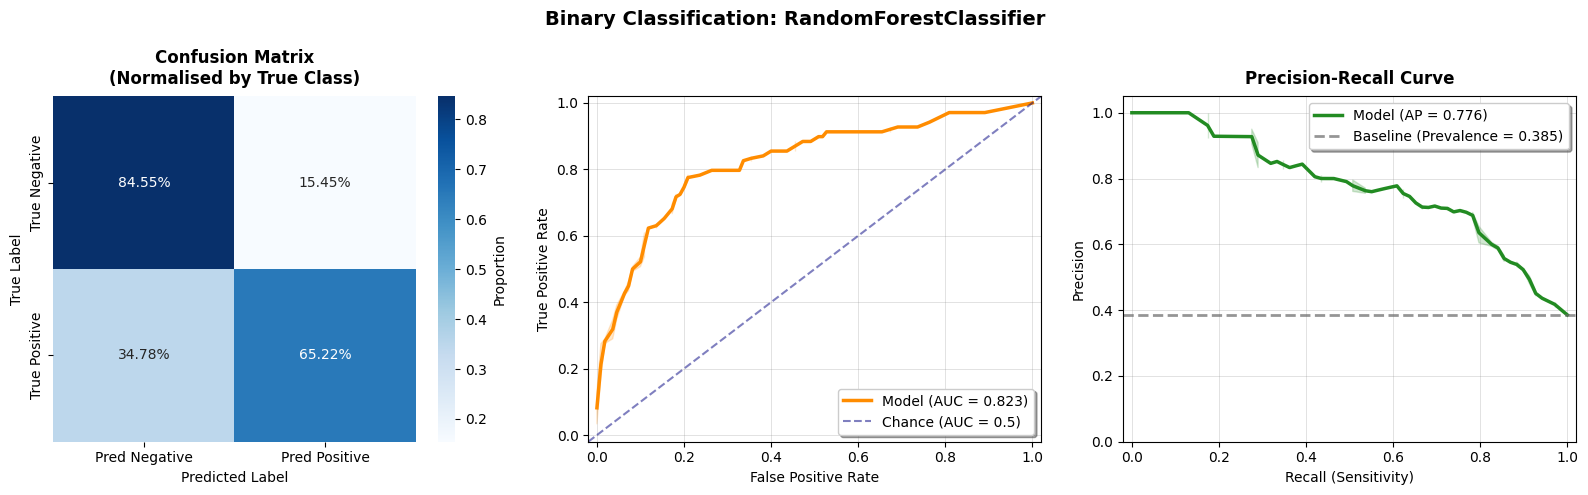

In [35]:
classification_evaluation(y_true=y_test, X_test=X_test, estimator=rf_pipe)

### 2) XGBClassifier

In [36]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from xgboost import XGBClassifier

preprocessor_xgb = ColumnTransformer(
	transformers=[("scaler", StandardScaler(), num_cols), ("categorical", OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore"), cat_cols)],
	remainder="drop",
)

xgb_pipe = Pipeline(steps=[("preprocessing", preprocessor_xgb), ("model", XGBClassifier(n_jobs=-1, random_state=42))])

In [37]:
from sklearn.metrics import classification_report

xgb_pipe.fit(X_train, y_train)
y_pred_xgb = xgb_pipe.predict(X_test)
y_pred_xgb_proba = xgb_pipe.predict_proba(X_test)
print(classification_report(y_true=y_test, y_pred=y_pred_xgb))

              precision    recall  f1-score   support

           0       0.83      0.84      0.83       110
           1       0.74      0.72      0.73        69

    accuracy                           0.79       179
   macro avg       0.78      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179



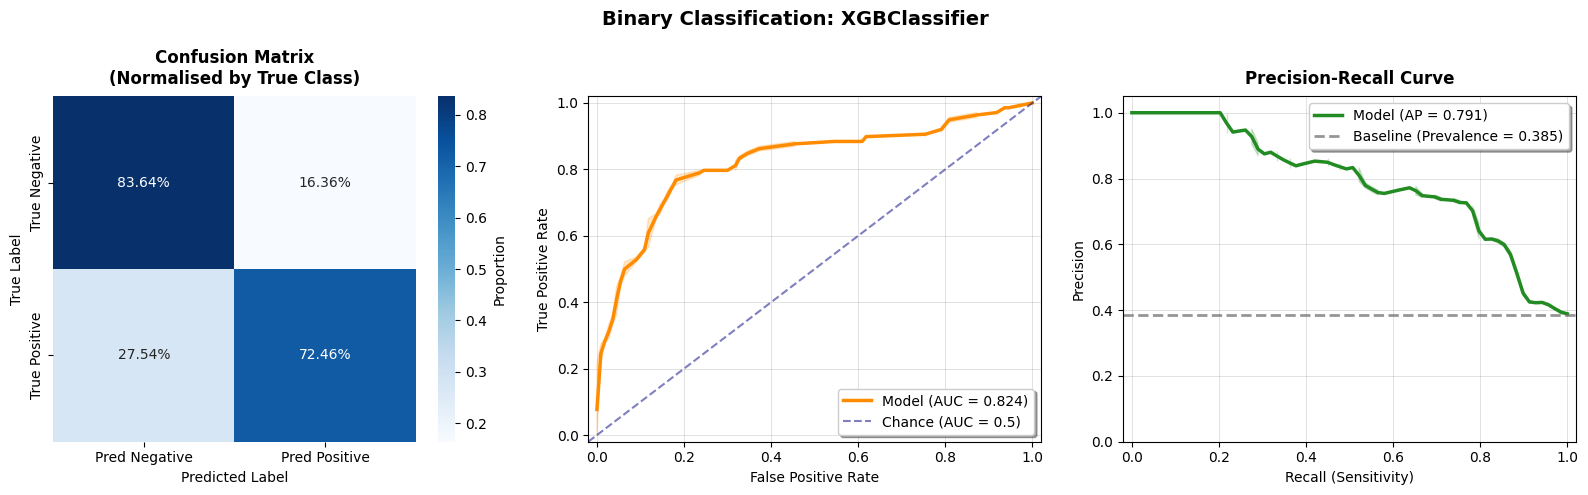

In [38]:
classification_evaluation(y_true=y_test, X_test=X_test, estimator=xgb_pipe)

### 3) Support Vector Machine (SVC with RBF kernel)

In [39]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC

preprocessor_svc = ColumnTransformer(
	transformers=[("scaler", StandardScaler(), num_cols), ("categorical", OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore"), cat_cols)],
	remainder="drop",
)

svc_pipe = Pipeline(
	steps=[
		("preprocessing", preprocessor_svc),
		(
			"model",
			SVC(
				kernel="rbf",
				C=1.0,
				gamma="scale",
				random_state=42,
				probability=True,  # Needed for predict_proba
			),
		),
	]
)

In [40]:
from sklearn.metrics import classification_report

svc_pipe.fit(X_train, y_train)
y_pred_svc = svc_pipe.predict(X_test)
y_pred_svc_proba = svc_pipe.predict_proba(X_test)
print(classification_report(y_true=y_test, y_pred=y_pred_svc))

              precision    recall  f1-score   support

           0       0.86      0.89      0.88       110
           1       0.82      0.77      0.79        69

    accuracy                           0.84       179
   macro avg       0.84      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179



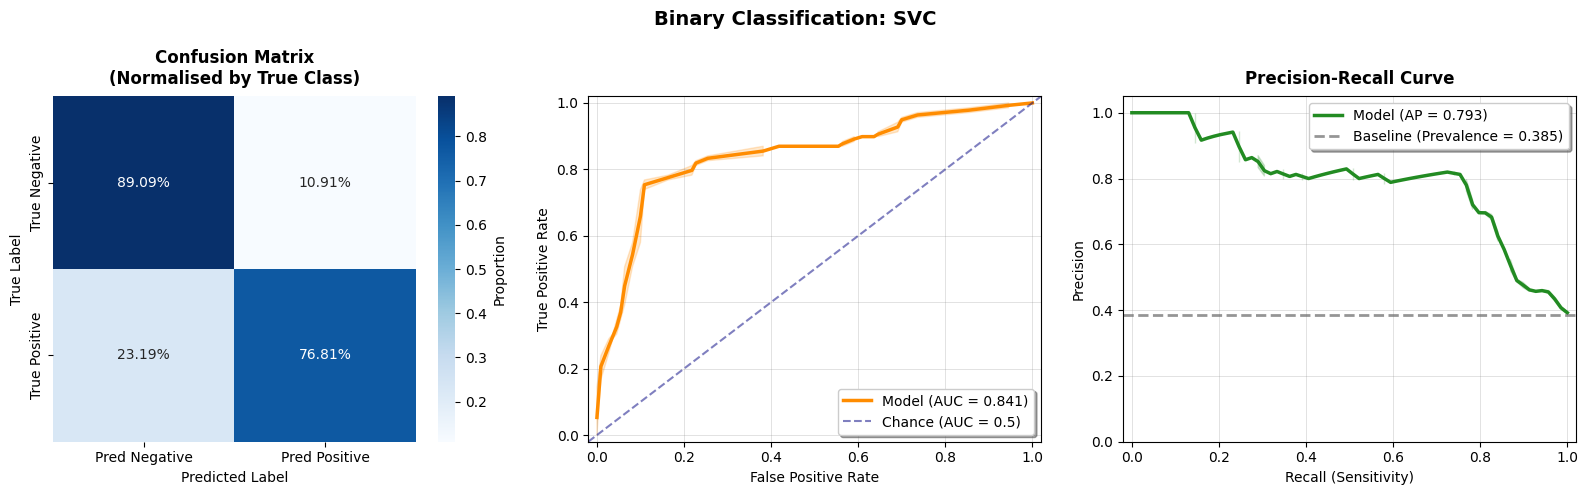

In [41]:
classification_evaluation(y_true=y_test, X_test=X_test, estimator=svc_pipe)

### Hyperparameter Tuning for SVC Model

In [42]:
from scipy.stats import loguniform, uniform
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC

param_distributions = {
	"svc__C": loguniform(1e-4, 1e4),
	"svc__gamma": ["scale", "auto"] + list(np.logspace(-5, 2, num=10)),
	"svc__kernel": ["rbf", "poly", "sigmoid"],
	"svc__degree": [2, 3, 4, 5],
	"svc__coef0": uniform(0, 5),
}

preprocessor_svc = ColumnTransformer(
	transformers=[
		("num", StandardScaler(with_mean=False), num_cols),
		("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols),
	],
	remainder="drop",
)

# Create a pipeline with preprocessing and SVC
pipe = Pipeline(
	steps=[
		("preprocessing", preprocessor_svc),
		("svc", SVC(random_state=42, cache_size=1000)),
	]
)

param_distributions = {
	"svc__kernel": ["rbf"],
	"svc__C": loguniform(1e-2, 1e3),
	"svc__gamma": loguniform(1e-5, 1e0),
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

svc_random = RandomizedSearchCV(
	estimator=pipe,
	param_distributions=param_distributions,
	n_iter=25,
	scoring="accuracy",
	n_jobs=-1,
	cv=cv,
	verbose=1,
	refit=True,
)

svc_random.fit(X_train, y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(with_mean=False),
                                                                               ['Age',
                                                                                'Fare',
                                                                                'FamilySize']),
                                                                              ('cat',
                                                                               OneHotEncoder(drop='first',
                                                                                             handle_unknown='ignore'),
                                                                               ['Sex',
                                                                                'Embarked',
                                                                                'Title',
                                                                                'CabinCode',
                                                                                'CabinMissing',
                                                                                'AgeMissing',
                                                                                'FamilyCat'])])),
                                             ('svc',
                                              SVC(cache_size=1000,
                                                  random_state=42))]),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'svc__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7aa0c0a6c890>,
                                        'svc__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7aa0c08b0500>,
                                        'svc__kernel': ['rbf']},
                   scoring='accuracy', verbose=1)

In [43]:
from sklearn.metrics import classification_report

svc_randomized = svc_random.best_estimator_

y_pred_randomized = svc_randomized.predict(X_test)
print(classification_report(y_true=y_test, y_pred=y_pred_randomized))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       110
           1       0.79      0.72      0.76        69

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.81       179
weighted avg       0.82      0.82      0.82       179



## Pipeline Factory, Custom Transformers, and Full Workflow

In [44]:
from sklearn.base import BaseEstimator, TransformerMixin


class ValueDecoder(BaseEstimator, TransformerMixin):
	"""
	Decode Titanic dataset codes to readable labels.

	Parameters
	----------
	decode_target : bool, default=False
		Whether to decode the 'Survived' column.
	"""

	def __init__(self, pclass: dict, embarked: dict):
		self.pclass = pclass
		self.embarked = embarked

	def fit(self, X, y=None):
		self.is_fitted_ = True
		return self

	def transform(self, X):
		X = X.copy()

		if "Pclass" in X.columns:
			X["Pclass"] = X["Pclass"].map(self.pclass)

		if "Embarked" in X.columns:
			X["Embarked"] = X["Embarked"].map(self.embarked)

		return X


class CodeExtractor(BaseEstimator, TransformerMixin):
	def __init__(self, cabin_col):
		self.cabin_col = cabin_col

	def fit(self, X, y=None):
		self.is_fitted_ = True
		return self

	def transform(self, X):
		X = X.copy()
		X["CabinCode"] = X[self.cabin_col].str[0]
		X = X.drop(self.cabin_col, axis=1)
		return X


class IsMissing(BaseEstimator, TransformerMixin):
	def __init__(self, missing_cols: list):
		self.missing_cols = missing_cols

	def fit(self, X, y=None):
		self.is_fitted_ = True
		return self

	def transform(self, X):
		X = X.copy()
		for col in self.missing_cols:
			X[f"Missing{col}"] = np.where(X[col].isna(), "Missing", "Non-missing")
		return X


class FamilyGrouping(BaseEstimator, TransformerMixin):
	def __init__(self, SibSp: str, Parch: str):
		self.SibSp = SibSp
		self.Parch = Parch

	def fit(self, X, y=None):
		self.is_fitted_ = True
		return self

	def transform(self, X):
		X = X.copy()
		X["FamilySize"] = X[self.SibSp] + X[self.Parch]
		X["FamilyCat"] = pd.cut(X["FamilySize"], bins=[0, 1, 4, np.inf], labels=["Alone", "Small", "Large"], right=False)

		return X


In [45]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


def make_feature_engineering() -> Pipeline:
	return Pipeline(
		steps=[
			("ValueDecoder", ValueDecoder(pclass={1: "First", 2: "Second", 3: "Third"}, embarked={"C": "Cherbourg", "Q": "Queenstown", "S": "Southampton"})),
			("CodeExtractor", CodeExtractor(cabin_col="Cabin")),
		]
	)


def make_categorical_pipe() -> Pipeline:
	return Pipeline(steps=[("encoder", OneHotEncoder(drop="first", handle_unknown="ignore"))])


def make_numerical_pipe() -> Pipeline:
	return Pipeline(steps=[("scaler", StandardScaler(with_mean=False))])


preprocessor = ColumnTransformer(
	transformers=[
		("categorical", make_categorical_pipe(), cat_cols),
		("numerical", make_numerical_pipe(), num_cols),
	],
	remainder="drop",
)

feature_eng = make_feature_engineering()

model_svc = SVC(
	kernel="rbf",
	C=1.0,
	gamma="scale",
	random_state=42,
	probability=True,
)

final_pipeline = Pipeline(
	steps=[
		("feature_engineering", feature_eng),
		("preprocessor", preprocessor),
		("model", model_svc),
	]
)

In [46]:
final_pipeline.fit(X_train, y_train)

Pipeline(steps=[('feature_engineering',
                 Pipeline(steps=[('ValueDecoder',
                                  ValueDecoder(embarked={'C': 'Cherbourg',
                                                         'Q': 'Queenstown',
                                                         'S': 'Southampton'},
                                               pclass={1: 'First', 2: 'Second',
                                                       3: 'Third'})),
                                 ('CodeExtractor',
                                  CodeExtractor(cabin_col='Cabin'))])),
                ('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked', 'Title',
                                                   'CabinCode', 'CabinMissing',
                                                   'AgeMissing', 'FamilyCat']),
                                                 ('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  ['Age', 'Fare',
                                                   'FamilySize'])])),
                ('model', SVC(probability=True, random_state=42))])

In [47]:
from sklearn.metrics import classification_report

final_pipeline.fit(X_train, y_train)
y_preds = final_pipeline.predict(X_test)
y_pred_proba = final_pipeline.predict_proba(X_test)
print(classification_report(y_true=y_test, y_pred=y_preds))

              precision    recall  f1-score   support

           0       0.85      0.90      0.88       110
           1       0.83      0.75      0.79        69

    accuracy                           0.84       179
   macro avg       0.84      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179



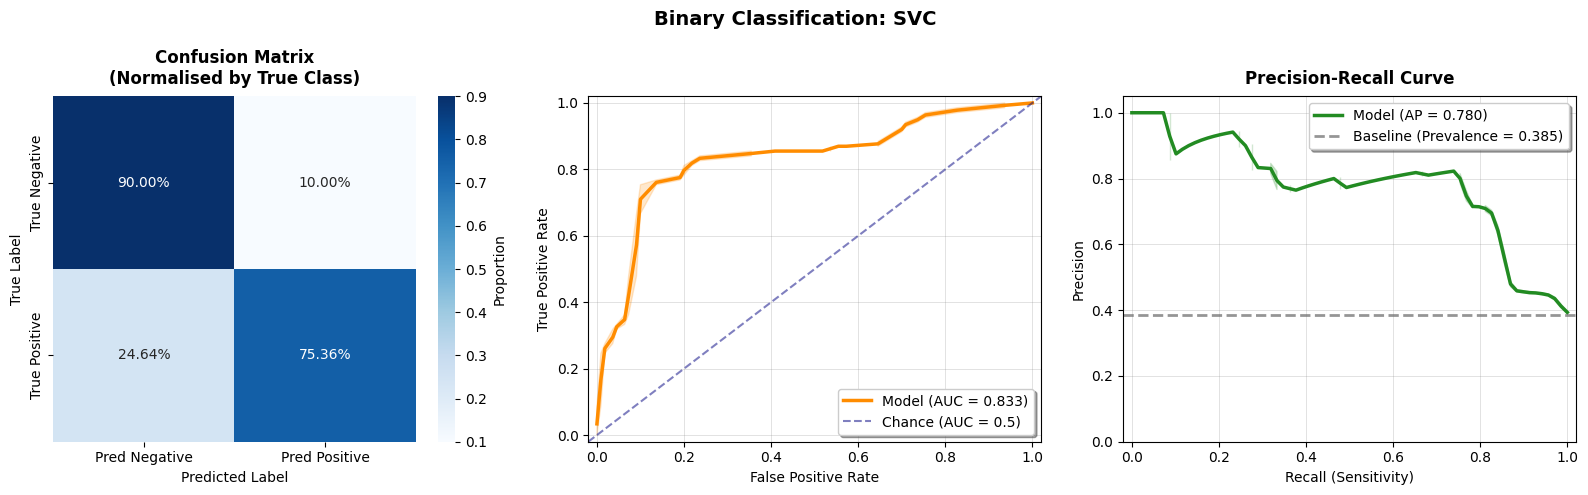

In [48]:
classification_evaluation(y_true=y_test, X_test=X_test, estimator=final_pipeline)